# 1. Packages

In [0]:
# Install TensorFlow
!pip install -q tensorflow-gpu==2.0.0-beta1

In [2]:
from google.colab import drive
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
%matplotlib inline

drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/CHL7001 Group Project/Data/Sample_and_Hold_NA_Constant')

print(tf.__version__)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
1.14.0


In [3]:
print("GPU Available: ", tf.test.is_gpu_available())

GPU Available:  True


# 2. Defining Functions

### 2.1 Preprocessing Functions

In [0]:
def drop_missing(train, val, threshold):
    # determine features based on training set
    percent_missing = train.apply(lambda x: sum(x == -1) / len(x))
    features_to_drop = percent_missing[percent_missing >= threshold].index.values
    # tell us what you're dropping
    print("Dropping Features:\n", features_to_drop)
    # drop features in training and val
    train_dropped = train.drop(features_to_drop, axis = 1, inplace = False)
    val_dropped = val.drop(features_to_drop, axis = 1, inplace = False)
    
    return(train_dropped, val_dropped)

In [0]:
from sklearn.utils import resample
# Upsampling
def upsampling(data, do = True, ratio = 1, set_seed = 123):

    if do == False:
        upsampled_data = data
    
    else:
        # separate minority and majority classes
        not_sepsis = data[data.SepsisLabel==0]
        sepsis = data[data.SepsisLabel==1]

        # get unique patients
        len_non_sepsis_ptx = len(np.unique(not_sepsis.index.values))
        sepsis_ptx = np.unique(sepsis.index.values)

        # upsample sepsis patients to desired ratio vs # of not_sepsis patients
        sepsis_ptx_upsampled = resample(sepsis_ptx,
                                    replace=True, # sample with replacement
                                    n_samples=int(len_non_sepsis_ptx * replacement_ratio), # custom proportion of not_sepsis
                                    random_state=set_seed) # reproducible results

        # new dataframe constructed from resampled patient list
        sepsis_upsampled = pd.concat( [ sepsis.groupby('filename').get_group(patient) for patient in sepsis_ptx_upsampled] )

        # combine majority and upsampled minority
        upsampled_data = pd.concat([not_sepsis, sepsis_upsampled])
        
    return upsampled_data

In [0]:
# Convert pd dataframe to LSTM format, adapted from MachineLearningMastery
def series_to_supervised(data, n_in=12, n_out=1, dropnan=True):
    values = data.values
    n_vars = 1 if values.ndim == 1 else data.shape[1]
    df = pd.DataFrame(values)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [0]:
# Convert pd dataframe into LSTM input
def LSTM_format(data, num_of_past_hours):
    
    # Note that this assumes that SepsisLabel is the last column of the dataframe
    data_X, data_y = data.iloc[:, :-1], data.iloc[:, -1]

    # Prepare for LSTM format
    data_X = data_X.groupby('filename').apply(series_to_supervised, n_in = num_of_past_hours).values

    # Reformat y to match
    data_y = data_y.groupby('filename').apply(series_to_supervised, n_in = num_of_past_hours).iloc[:, -1].values

    # reshape into 3d LSTM input (obs, timesteps, features)
    data_X = data_X.reshape((data_X.shape[0], num_of_past_hours+1, int(data_X.shape[1] / (num_of_past_hours + 1))))

    return data_X, data_y

In [0]:
def confusion_matrix(model, data_X, data_y):
    pred_y = model.predict_classes(data_X)
    confusion_matrix = tf.math.confusion_matrix(
        data_y,
        pred_y,
    )
    confusion_matrix= pd.DataFrame(confusion_matrix.numpy())
    confusion_matrix.rename(columns={0:'Predicted Sepsis: No', 1: 'Predicted Sepsis: Yes'}, 
                     index={0:'Actual Sepsis: No',1:'Actual Sepsis: Yes'}, 
                     inplace=True)
    # Other metrics
    SP = confusion_matrix.iloc[0,0] / (confusion_matrix.iloc[0,0] + confusion_matrix.iloc[0,1])
    SN = confusion_matrix.iloc[1,1] / (confusion_matrix.iloc[1,0] + confusion_matrix.iloc[1,1])
    PPV = confusion_matrix.iloc[1,1] / (confusion_matrix.iloc[0,1] + confusion_matrix.iloc[1,1])
    
    Acc = (confusion_matrix.iloc[0,0] + confusion_matrix.iloc[1,1]) /  (confusion_matrix.iloc[0,0] + confusion_matrix.iloc[0,1] + confusion_matrix.iloc[1,0] + confusion_matrix.iloc[1,1])
    F1 = 2 * (PPV * SN) / (PPV + SN)

    print(confusion_matrix)
    print(
        '\n\nSpecificity:\t' + '{:.3}'.format(SP),
        '\nSensitivity:\t' + '{:.3}'.format(SN),
        '\nPrecision:\t' + '{:.3}'.format(PPV)
    )
    print(
        '\nAccuracy:\t' + '{:.3}'.format(Acc),
        '\nF1 Score:\t' + '{:.3}'.format(F1)
    )

In [9]:
import keras.backend as K

def weighted_accuracy(y_true, y_pred):
  y_true = tf.squeeze(y_true)
  y_pred = tf.squeeze(y_pred)
  
  cmat = tf.math.confusion_matrix(y_true, y_pred, dtype=tf.dtypes.float32)
  
  # weighted components of confusion matrix
  TN = cmat[0,0]*0
  TP = cmat[1,1]*1     
  FN = cmat[1,0]*2
  FP = cmat[0,1]*0.05 
    
  acc = K.division(K.sum(TN, FP), K.sum(TN, TP, FN, FP))

  return acc

Using TensorFlow backend.


# 3. Data Import

Note that they have shifted the sepsis labels 6 hours ahead in the data they provided us so they are asking us to predict sepsis 6 hours early

### 2.1 Training Data

In [0]:
train_data = pd.read_csv('train_sample_and_hold_NA_constant.csv')
train_data = train_data[train_data.filename.isin(train_data.filename.unique()[0:1001])].set_index('filename').drop(['Unit1','Unit2', 'GotSepsis', 'Hospital'], axis=1)
#train_data = train_data.set_index('filename').drop(['Unit1','Unit2', 'GotSepsis', 'Hospital'], axis=1)

### 2.2 Validation Data

In [0]:
val_data = pd.read_csv('val_sample_and_hold_NA_constant.csv')
val_data = val_data[val_data.filename.isin(val_data.filename.unique()[0:501])].set_index('filename').drop(['Unit1','Unit2', 'GotSepsis', 'Hospital'], axis=1)
#val_data = val_data.set_index('filename').drop(['Unit1','Unit2', 'GotSepsis', 'Hospital'], axis=1)

# 4. Data Preprocessing

In [0]:
# HYPERPARAMETERS
    # remove variables with missing above this threshold
missing_threshold = 0.7
    # specify number of past hours to keep
num_of_past_hours = 17
    # resample septic to desired ratio vs non-septic cases
replacement_ratio = 0.75

In [13]:
# Drop features missing above threshold
train_dropped, val_dropped = drop_missing(train_data, val_data, threshold = missing_threshold)

# Upsample septic cases to desired ratio vs non-septic
upsampled_train = upsampling(train_dropped, ratio = replacement_ratio, set_seed = 27)

# Convert to LSTM format
train_X, train_y = LSTM_format(upsampled_train, num_of_past_hours)
val_X, val_y = LSTM_format(val_dropped, num_of_past_hours)

Dropping Features:
 ['AST' 'Alkalinephos' 'Bilirubin_total']


In [14]:
train_y

array([0, 0, 0, ..., 0, 0, 0])

In [15]:
print(train_X.shape, train_y.shape, val_X.shape, val_y.shape)

(28285, 18, 31) (28285,) (11435, 18, 31) (11435,)


# 4. Building the LSTM

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 18, 128)           81920     
_________________________________________________________________
dropout_8 (Dropout)          (None, 18, 128)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)              

Text(0, 0.5, 'Loss')

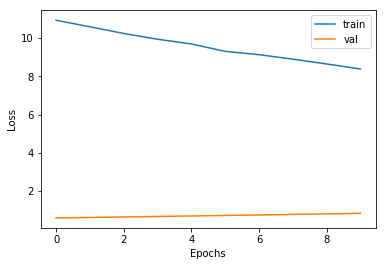

In [18]:
# Hyperparameters
lr = 0.001
epochs = 10
decay = 0.0
batch_size = 48
momentum= 0.0
sepsis_weight = 50
lstm_units = 128
dropout=0.5
dense1_nodes=128
dense2_nodes=64
optimizer='Adadelta'
es_patience=10

#  Model Architecture
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(lstm_units, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(tf.keras.layers.Dropout(dropout))

model.add(tf.keras.layers.LSTM(lstm_units))
model.add(tf.keras.layers.Dropout(dropout))
          
model.add(tf.keras.layers.Dense(dense1_nodes))
model.add(tf.keras.layers.LeakyReLU(alpha=0.05))
model.add(tf.keras.layers.Dropout(dropout))
          
model.add(tf.keras.layers.Dense(dense2_nodes))
model.add(tf.keras.layers.LeakyReLU(alpha=0.05))
model.add(tf.keras.layers.Dropout(dropout))
          
model.add(tf.keras.layers.Dense(1, activation= 'sigmoid'))

model.summary()

# Select and Tune Optimizer; I've included other potential ones below for quicker tuning. Some values are left as default as per recommendations from: https://keras.io/optimizers/
optimizer_choices = {
    "RMSprop":tf.keras.optimizers.RMSprop(learning_rate=lr, decay=decay, momentum=momentum),
    "Adam":tf.keras.optimizers.Adam(learning_rate=lr, decay=decay),
    "Adadelta":tf.keras.optimizers.Adadelta(learning_rate=lr, decay=decay),
    "SGD":tf.keras.optimizers.SGD(learning_rate=lr, momentum=momentum, decay=decay)}

optim = optimizer_choices[optimizer]

# Compile Model
model.compile(optimizer= optim,
              loss= 'binary_crossentropy',
              metrics=['accuracy'])

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=es_patience)

# Fit network
history = model.fit(train_X, train_y, epochs= epochs, batch_size=batch_size, validation_data=(val_X, val_y), verbose=2, shuffle=False, class_weight={0:1, 1:sepsis_weight}, callbacks=[es])

# Plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

# 5. Evaluation

## Upsampled Training Set

In [19]:
confusion_matrix(model, train_X, train_y)

AttributeError: ignored

## Original Training Set

In [0]:
# Get original training set
train_original_X, train_original_y = LSTM_format(train_dropped, num_of_past_hours)
confusion_matrix(model, train_original_X, train_original_y)

## Validation Set

In [0]:
confusion_matrix(model, val_X, val_y)

### follow up

Lots of parameters to explore. Consider using something that automatically searches through them and tracks experiments, such as NNI

https://github.com/microsoft/nni

https://nni.readthedocs.io/en/latest/Tutorial/QuickStart.html